In [1]:
# ===============================
# 1. IMPORT LIBRARIES
# ===============================

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [2]:
# ===============================
# 2. DOWNLOAD APPLE STOCK DATA
# ===============================
current_date = datetime.now()

df = yf.download("AAPL", start="2010-01-01", end=current_date)

# Fix MultiIndex columns (yfinance issue)
df.columns = [col[0] for col in df.columns]

df.head()


/tmp/ipython-input-3631529485.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2010-01-01", end=current_date)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,6.418384,6.433079,6.369498,6.400989,493729600
2010-01-05,6.429480,6.465769,6.395589,6.436078,601904800
2010-01-06,6.327212,6.454974,6.320614,6.429482,552160000
2010-01-07,6.315515,6.358102,6.269628,6.350604,477131200
2010-01-08,6.357500,6.358100,6.269927,6.307115,447610800


In [3]:
# ===============================
# 3. BASIC VISUALIZATION
# ===============================
fig = px.line(
    df,
    x=df.index,
    y="Close",
    title="Apple Stock Closing Price"
)
fig.show()


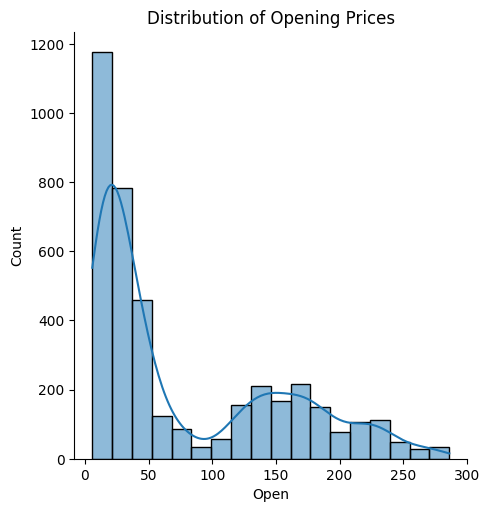

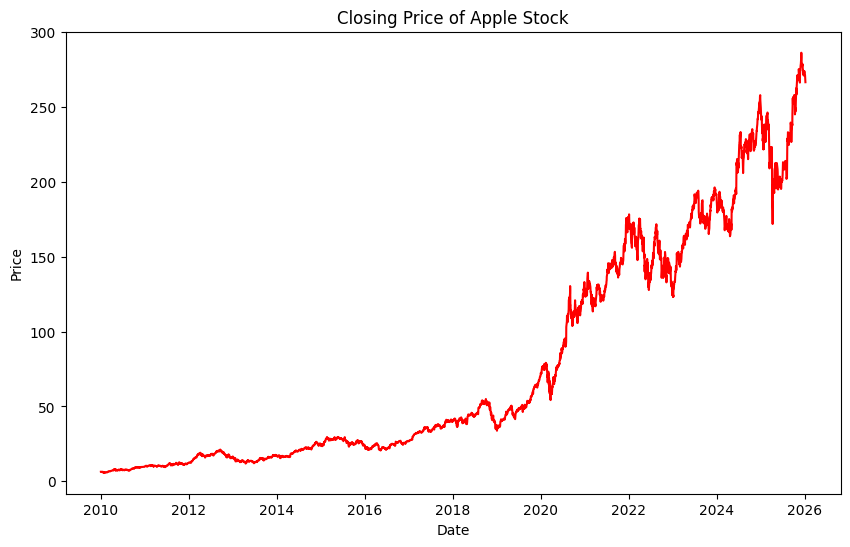

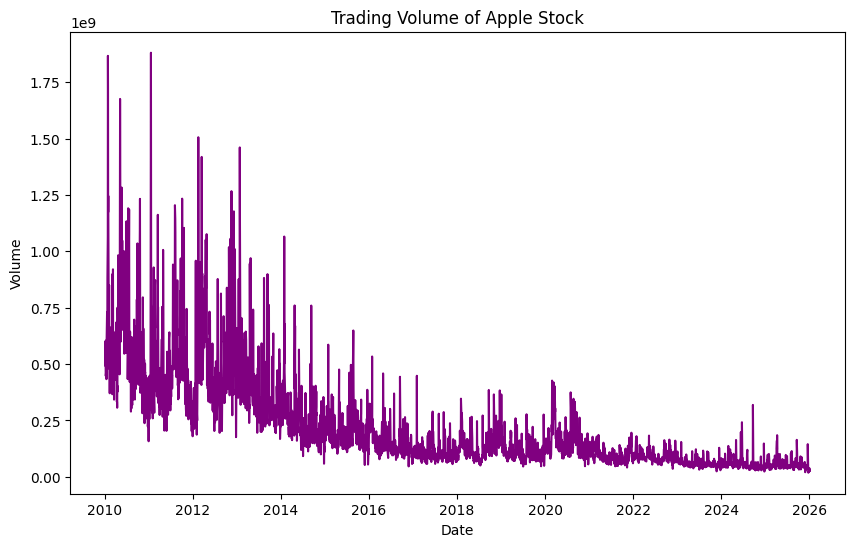

In [4]:
# ===============================
# 4. DISTRIBUTION & BASIC PLOTS
# ===============================
sns.displot(df["Open"], kde=True)
plt.title("Distribution of Opening Prices")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(df["Close"], color="red")
plt.title("Closing Price of Apple Stock")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(df["Volume"], color="purple")
plt.title("Trading Volume of Apple Stock")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()


In [5]:
# ===============================
# 5. MOVING AVERAGES
# ===============================
moving_avg = [10, 20, 30]

for ma in moving_avg:
    df[f"MA for {ma} days"] = df["Close"].rolling(ma).mean()

fig = px.line(
    df,
    x=df.index,
    y=["Close", "MA for 10 days", "MA for 20 days", "MA for 30 days"],
    title="Apple Stock Moving Averages"
)
fig.show()


In [6]:
# ===============================
# 6. DAILY RETURNS
# ===============================
df["dailyReturn"] = df["Close"].pct_change()

fig = px.line(
    df,
    x=df.index,
    y="dailyReturn",
    title="Apple Daily Returns"
)
fig.show()

fig = px.histogram(
    df,
    x="dailyReturn",
    title="Distribution of Daily Returns"
)
fig.show()

# Average daily return
df["dailyReturn"].mean()


np.float64(0.0010834926480616975)

In [7]:
# ===============================
# 7. VALUE AT RISK (VaR)
# ===============================
VaR_95 = np.percentile(df["dailyReturn"].dropna(), 5)
VaR_95


np.float64(-0.026704148919537984)

In [8]:
# ===============================
# 8. PREPARE DATA FOR LSTM
# ===============================
df_close = df[["Close"]]

close_scaler = MinMaxScaler(feature_range=(0,1))
scaled_close = close_scaler.fit_transform(df_close)


In [9]:
# ===============================
# 9. CREATE TIME SERIES DATA
# ===============================
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_close, time_step)


In [10]:
# ===============================
# 10. TRAIN-TEST SPLIT
# ===============================
split = int(len(X) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [11]:
# ===============================
# 11. BUILD LSTM MODEL
# ===============================
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(60,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# ===============================
# 12. TRAIN MODEL
# ===============================
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - loss: 0.0089 - val_loss: 0.0020
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 6.0295e-04 - val_loss: 7.1491e-04
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 5.0194e-04 - val_loss: 0.0024
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 4.3823e-04 - val_loss: 0.0039
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 4.4953e-04 - val_loss: 9.0284e-04
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 4.2012e-04 - val_loss: 0.0012
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 3.7588e-04 - val_loss: 0.0028
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 4.1860e-04 - val_loss: 0.0036
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 4.1151e-04 - val_loss: 0.0014
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 4.4435e-04 - val_loss: 0.0024
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 3.1378e-04 - val_l

In [13]:
# ===============================
# 13. PREDICTION & INVERSE SCALING
# ===============================
predicted_price = model.predict(X_test)

predicted_price = close_scaler.inverse_transform(predicted_price)
actual_price = close_scaler.inverse_transform(y_test.reshape(-1,1))


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


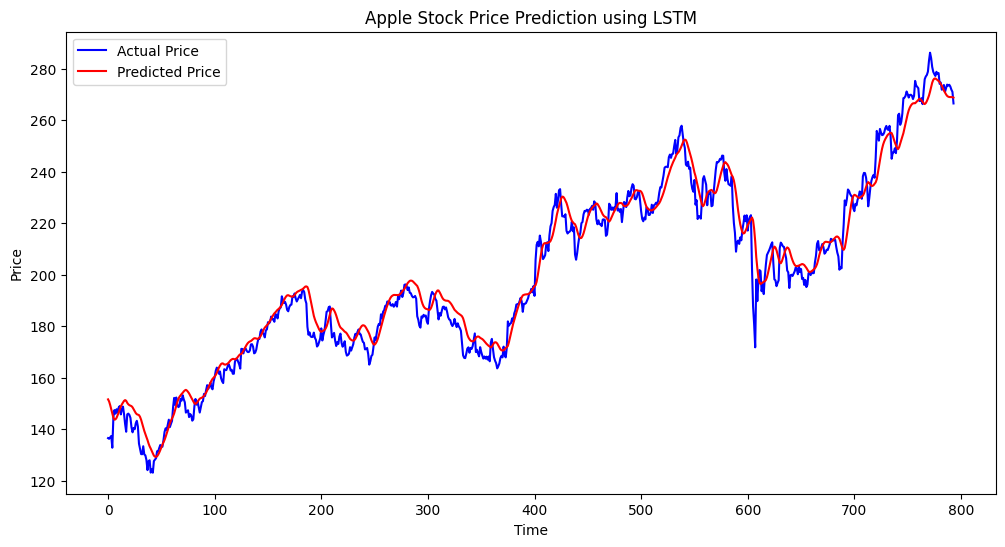

In [14]:
# ===============================
# 14. VISUALIZE PREDICTIONS
# ===============================
plt.figure(figsize=(12,6))
plt.plot(actual_price, label="Actual Price", color="blue")
plt.plot(predicted_price, label="Predicted Price", color="red")
plt.title("Apple Stock Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
